<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch_snippets.torch_loader import Report
import matplotlib.pyplot as plt;

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 9.91M/9.91M [00:11<00:00, 883kB/s]


Extracting MNIST/MNIST\raw\train-images-idx3-ubyte.gz to MNIST/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 100kB/s]


Extracting MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 956kB/s]


Extracting MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 8.17MB/s]

Extracting MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST/MNIST\raw



In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [3]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [4]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [5]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

EPOCH: 1.000  train_loss: 2914.863  val_kld: 459.614  train_mean: -0.001  val_log_var: -0.274  val_recon: 1910.570  train_kld: 266.463  train_recon: 2648.400  val_loss: 2370.183  val_mean: 0.003  train_log_var: -0.161  (14.87s - 133.79s remaining)


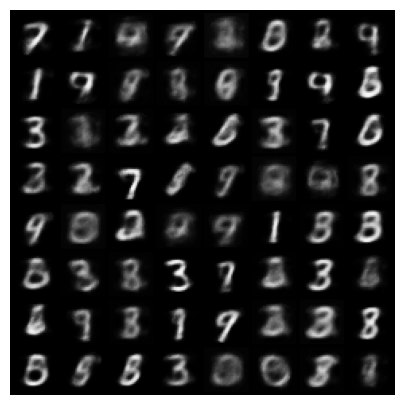

EPOCH: 2.000  train_loss: 2212.799  val_kld: 550.117  train_mean: -0.001  val_log_var: -0.334  val_recon: 1541.838  train_kld: 496.002  train_recon: 1716.797  val_loss: 2091.955  val_mean: 0.001  train_log_var: -0.301  (29.83s - 119.31s remaining)


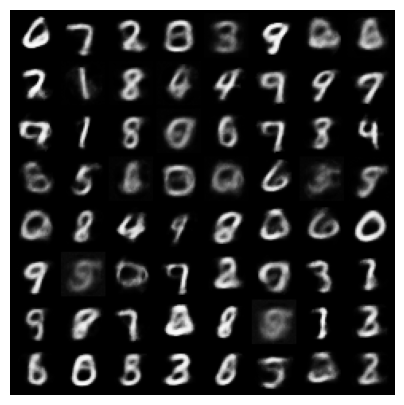

EPOCH: 3.000  train_loss: 2059.764  val_kld: 567.672  train_mean: 0.000  val_log_var: -0.357  val_recon: 1432.831  train_kld: 548.431  train_recon: 1511.333  val_loss: 2000.503  val_mean: 0.003  train_log_var: -0.337  (45.86s - 107.00s remaining)


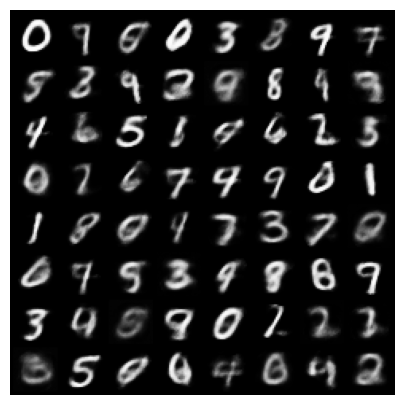

EPOCH: 4.000  train_loss: 1996.354  val_kld: 575.446  train_mean: 0.000  val_log_var: -0.363  val_recon: 1376.656  train_kld: 572.623  train_recon: 1423.731  val_loss: 1952.102  val_mean: 0.002  train_log_var: -0.354  (65.15s - 97.73s remaining)


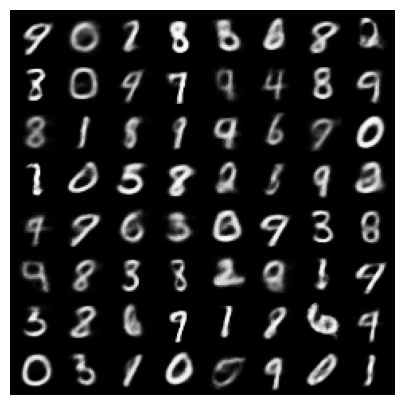

EPOCH: 5.000  train_loss: 1956.287  val_kld: 595.950  train_mean: 0.000  val_log_var: -0.373  val_recon: 1327.857  train_kld: 589.098  train_recon: 1367.189  val_loss: 1923.807  val_mean: 0.003  train_log_var: -0.365  (80.43s - 80.43s remaining)


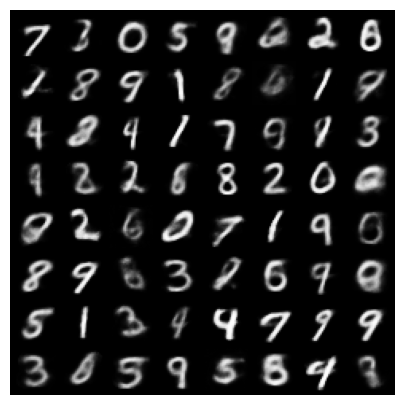

EPOCH: 6.000  train_loss: 1926.085  val_kld: 604.175  train_mean: 0.000  val_log_var: -0.380  val_recon: 1291.391  train_kld: 601.313  train_recon: 1324.771  val_loss: 1895.566  val_mean: 0.003  train_log_var: -0.373  (97.40s - 64.94s remaining)


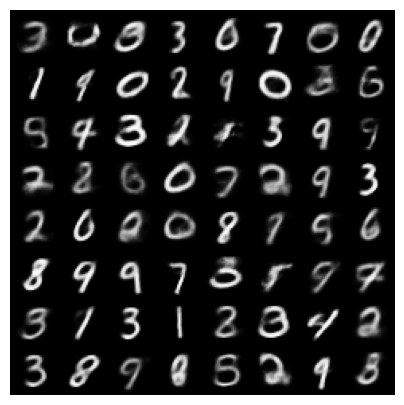

EPOCH: 7.000  train_loss: 1903.902  val_kld: 611.881  train_mean: 0.000  val_log_var: -0.381  val_recon: 1268.368  train_kld: 610.872  train_recon: 1293.031  val_loss: 1880.249  val_mean: 0.001  train_log_var: -0.380  (113.64s - 48.70s remaining)


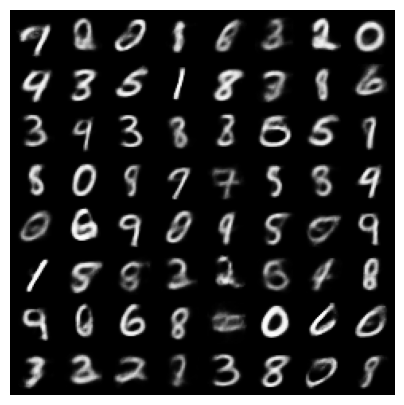

EPOCH: 8.000  train_loss: 1884.800  val_kld: 619.456  train_mean: 0.000  val_log_var: -0.388  val_recon: 1245.651  train_kld: 618.470  train_recon: 1266.330  val_loss: 1865.108  val_mean: -0.005  train_log_var: -0.385  (129.14s - 32.28s remaining)


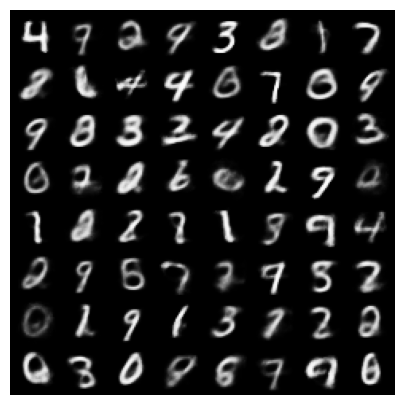

EPOCH: 9.000  train_loss: 1871.727  val_kld: 625.833  train_mean: 0.000  val_log_var: -0.386  val_recon: 1232.107  train_kld: 623.821  train_recon: 1247.906  val_loss: 1857.940  val_mean: 0.003  train_log_var: -0.389  (144.02s - 16.00s remaining)


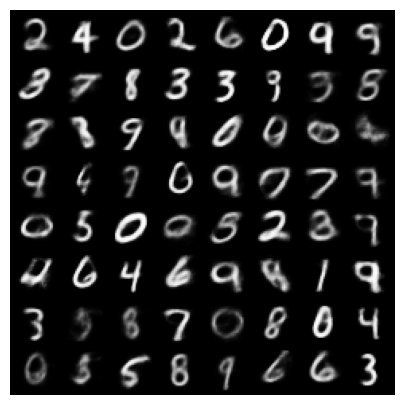

EPOCH: 10.000  train_loss: 1856.863  val_kld: 629.080  train_mean: 0.001  val_log_var: -0.395  val_recon: 1211.519  train_kld: 627.748  train_recon: 1229.115  val_loss: 1840.600  val_mean: 0.002  train_log_var: -0.391  (160.27s - 0.00s remaining)


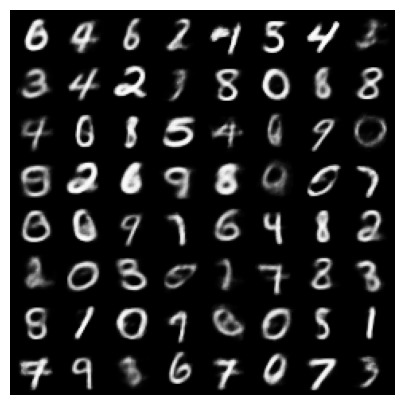

In [9]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|███████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 567.48it/s]


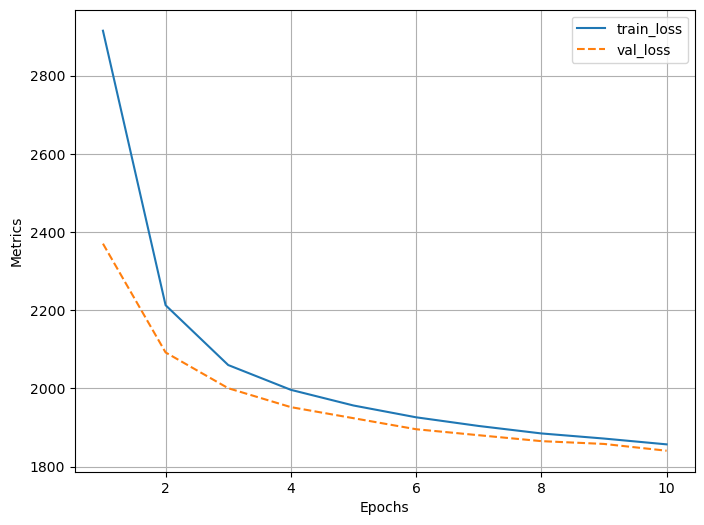

In [13]:
log.plot_epochs(['train_loss','val_loss'])